# Visual Document NER

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
os.environ['JSL_OCR_LICENSE'] = license
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

In [2]:
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [3]:
#%pip install ../../python/dist/spark-ocr-3.9.0+spark30.tar.gz

In [4]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

### Initialize Spark session

In [5]:
from sparkocr import start
from pyspark import SparkConf

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 3.2.1
Spark NLP version: 4.4.0
Spark NLP for Healthcare version: 4.3.0
Spark OCR version: 4.4.0rc1



## Load test images

In [6]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/jose/....|2023-04-12 00:21:...|421333|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+



## Display images


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


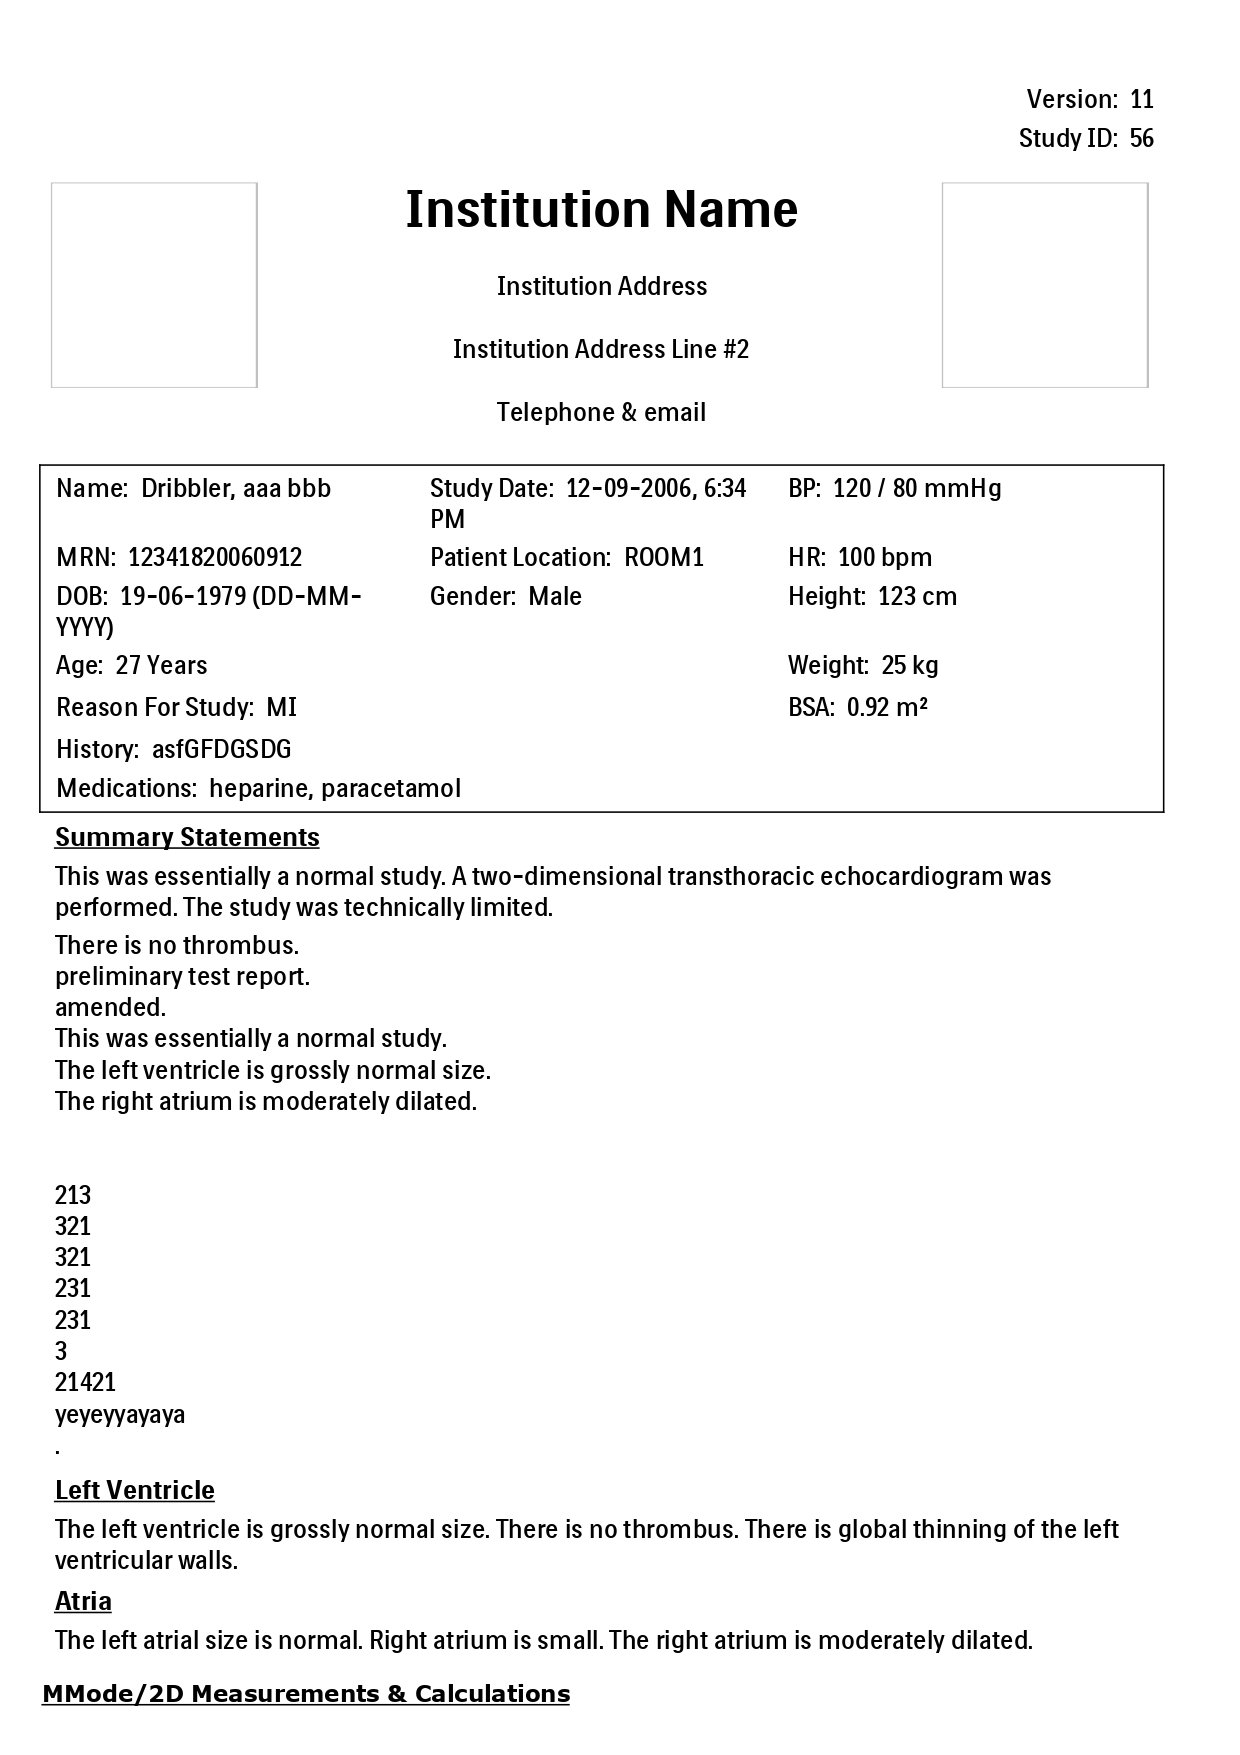

In [7]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Define pipeline

In [9]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])


doc_ner = VisualDocumentNer()\
    .pretrained("lilt_roberta_funsd_v1", "en", "clinical/ocr")\
    .setInputCol("hocr")\
    .setOutputCol("entities")

draw = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    doc_ner,
    draw
])

lilt_roberta_funsd_v1 download started this may take some time.
Approximate size to download 419.6 MB


## Call pipeline

In [10]:
results = pipeline.transform(bin_df).cache()

## Show results

In [11]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn("exploded_entities", f.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)
            

/home/jose/.local/lib/python3.7/site-packages/pyspark/sql/column.py:326: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  FutureWarning


+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|filename |exploded_entities                                                                                                                                      |
+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|form1.jpg|{named_entity, 0, 7, b-question, {x -> 1027, y -> 89, height -> 19, confidence -> 109, token -> Version, ocr_confidence -> 96, width -> 90}, []}       |
|form1.jpg|{named_entity, 8, 8, i-question, {x -> 1027, y -> 89, height -> 19, confidence -> 80, token -> :, ocr_confidence -> 96, width -> 90}, []}              |
|form1.jpg|{named_entity, 8, 10, b-question, {x -> 1132, y -> 89, height -> 19, confidence -> 38, token -> 11, ocr_confidence -> 96, width -> 21}, []}            |
|form1.jpg|{name


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


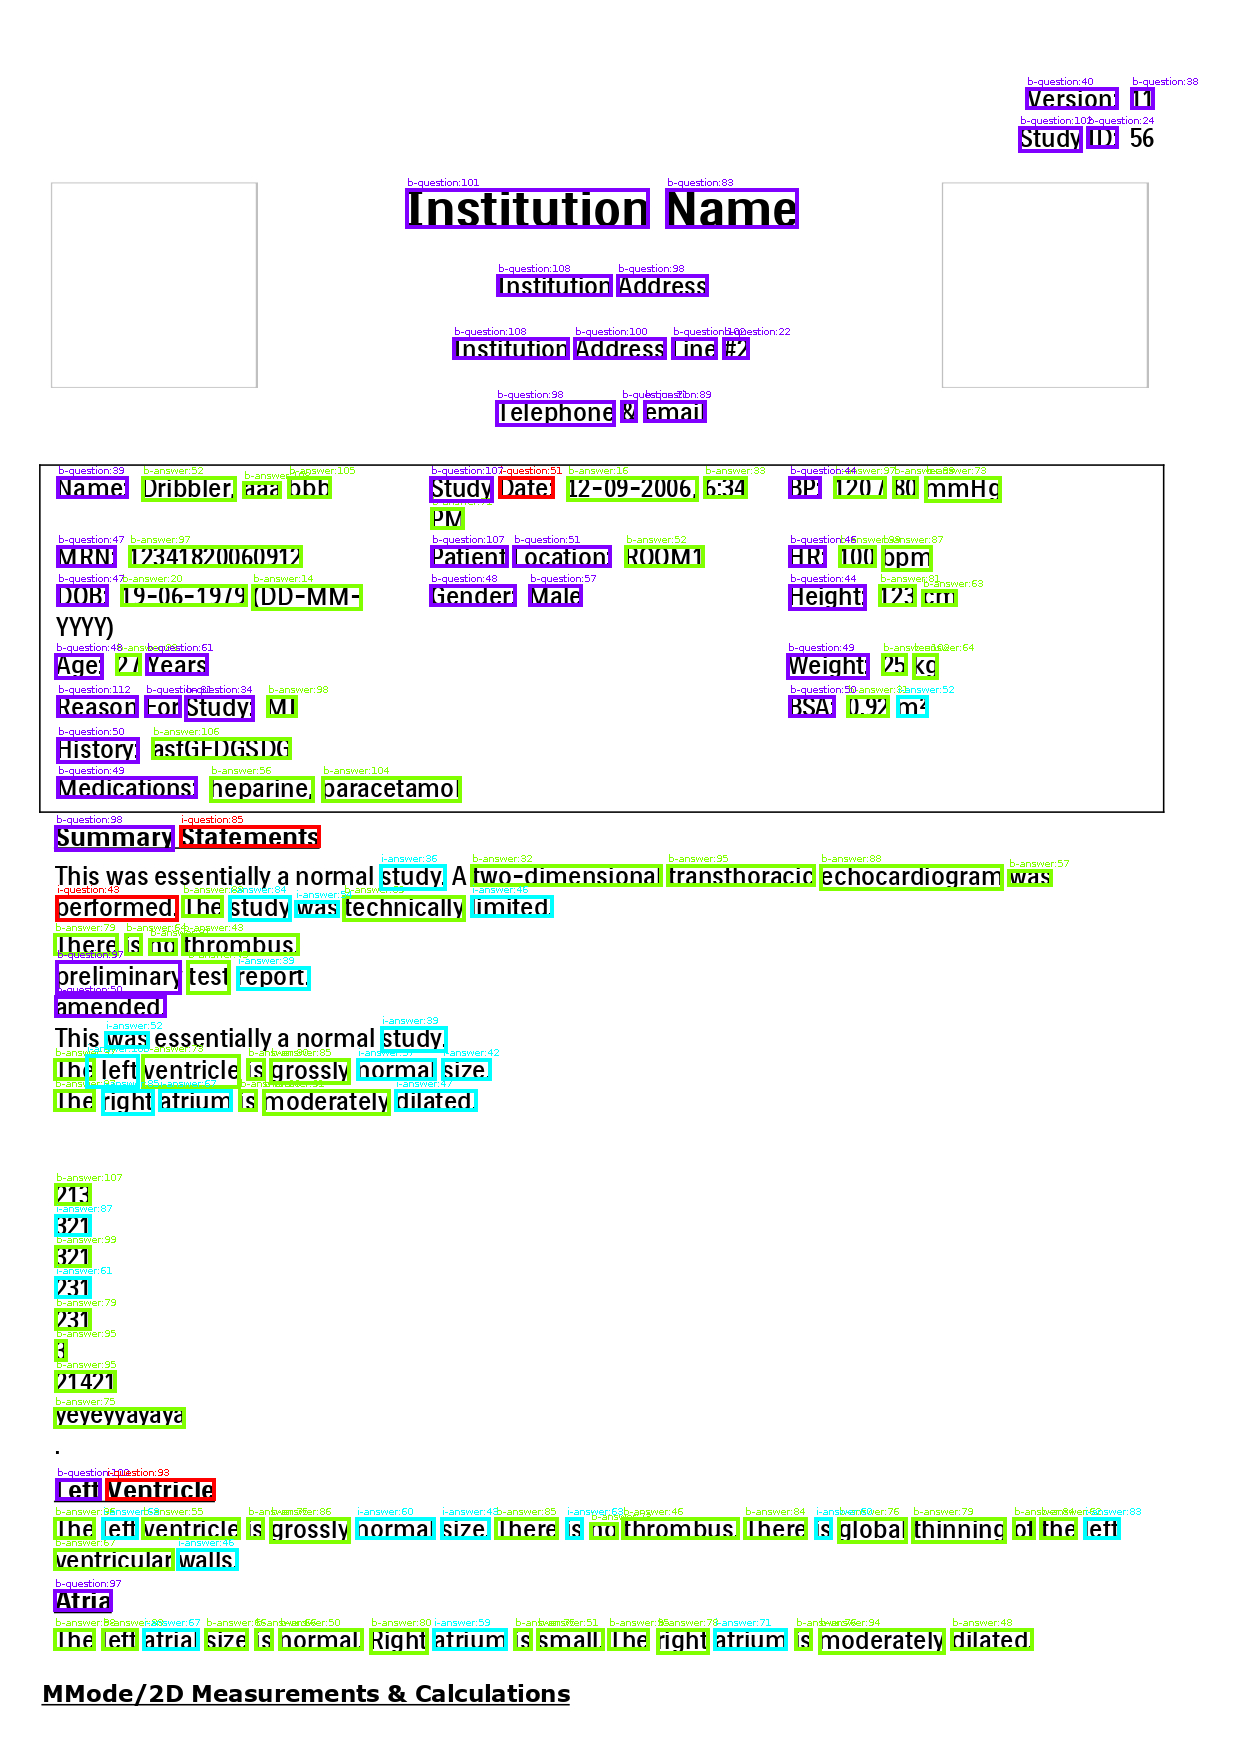

In [12]:
display_images(results, "image_with_annotations", width=1000)

## Customize labels

lilt_roberta_funsd_v1 download started this may take some time.
Approximate size to download 419.6 MB

    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


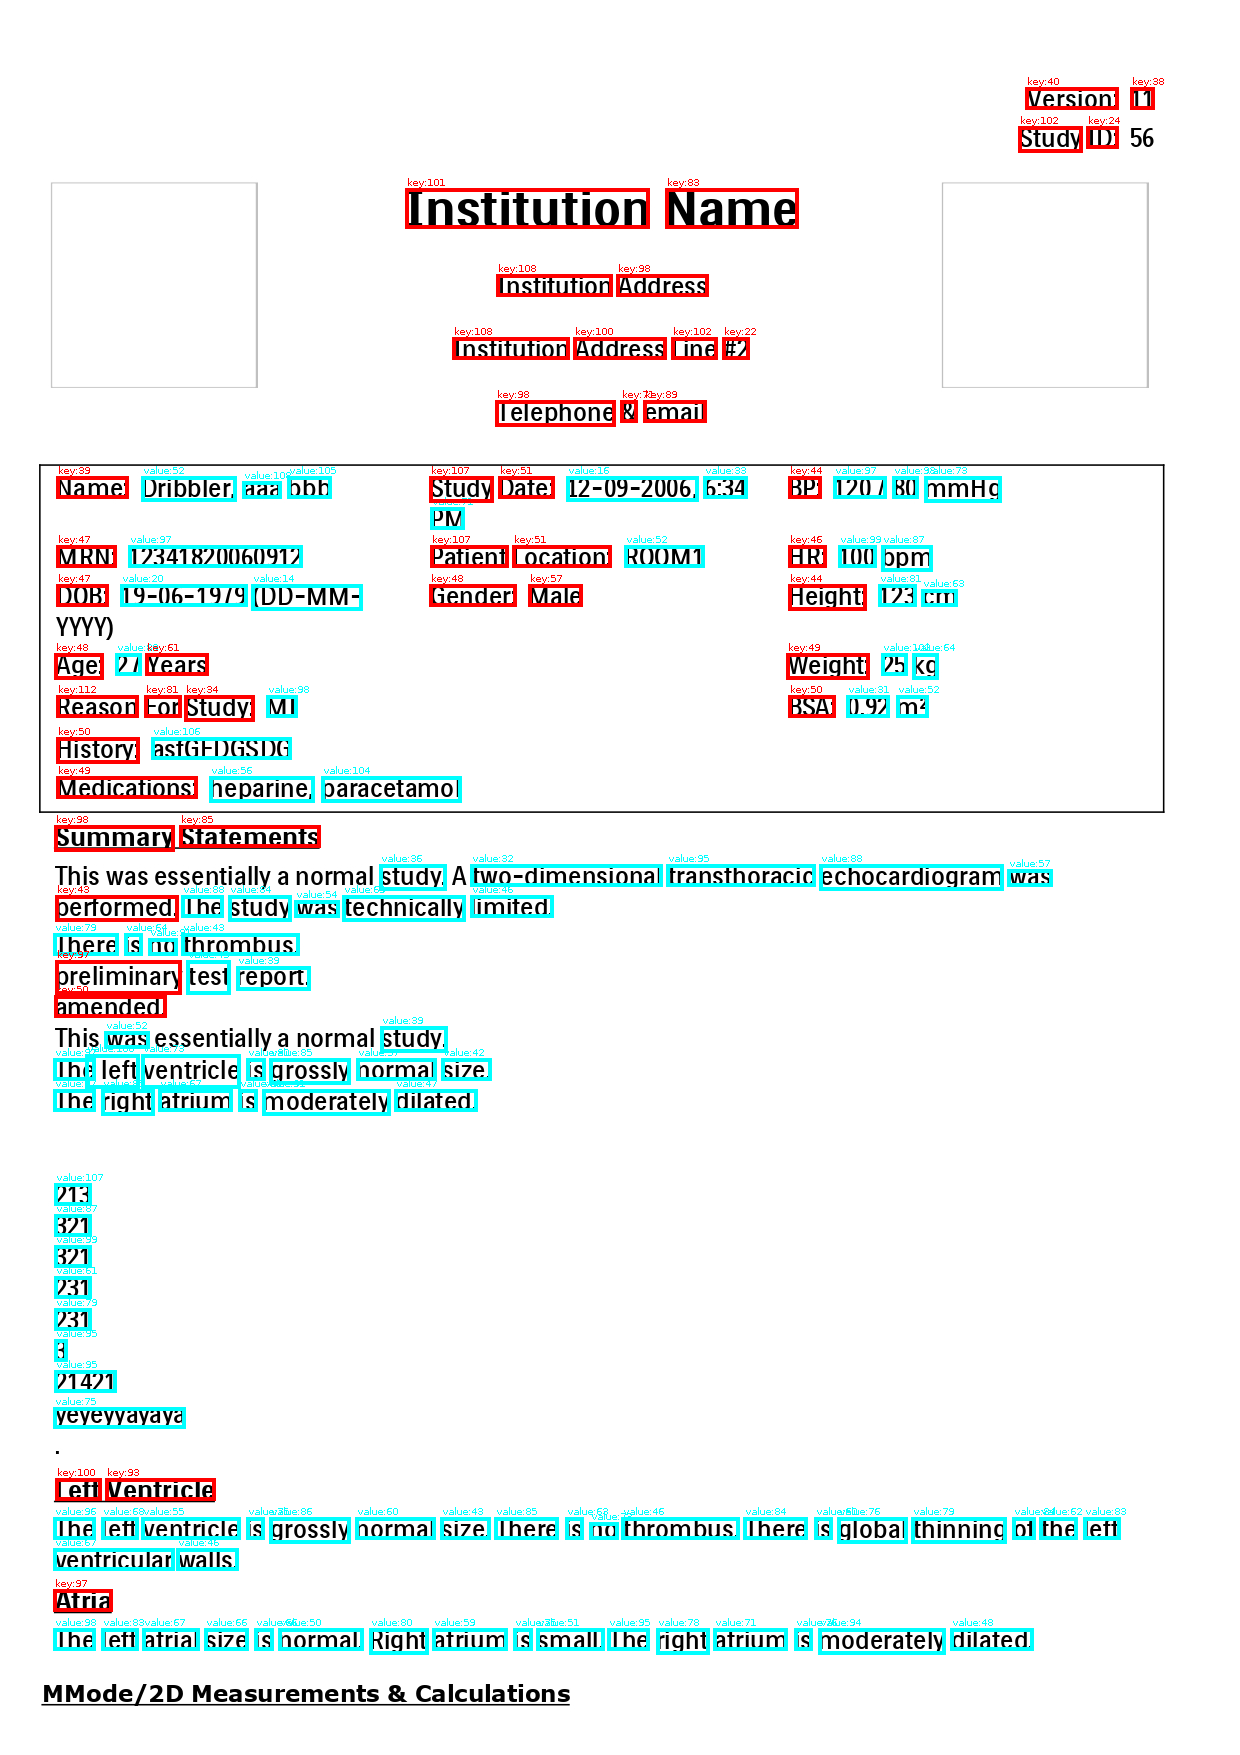

In [13]:
binary_to_image_ = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr_ = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

doc_ner_cust = VisualDocumentNer()\
    .pretrained("lilt_roberta_funsd_v1", "en", "clinical/ocr")\
    .setInputCol("hocr")\
    .setOutputCol("entities")\
    .setLabels(["other",
                "header",
                "header",
                "key",
                "key",
                "value",
                "value"])\
    .setWhiteList(["header",
                   "key",
                   "value"])

draw_ = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)


# OCR pipeline
pipeline_cust = PipelineModel(stages=[
    binary_to_image_,
    img_to_hocr_,
    doc_ner_cust,
    draw_
])

results_cust = pipeline_cust.transform(bin_df).cache()
display_images(results_cust, "image_with_annotations", width=1000)